In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models

In [0]:
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader

In [5]:
#resnet18 = models.resnet18(num_classes=10, pretrained=False)

transform = transforms.ToTensor()
batch_size=64

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [30000, 20000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 85592710.33it/s]                               


Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [7]:
import time
num_epochs = 20
learning_rates = [0.001, 0.1, 0.7, 0.99]
losses = []
for lr in learning_rates:
  resnet18 = models.resnet18(num_classes=10, pretrained=False)
  resnet18 = resnet18.cuda()
  opt = torch.optim.SGD(resnet18.parameters(), lr=lr)
  train_loss = []
  val_accuracy = []
  
  for epoch in range(num_epochs):
      start_time = time.time()
      k = 0
      resnet18.train(True)
      for (X_batch, y_batch) in trainloader:
          loss = compute_loss(X_batch, y_batch)
          loss.backward()
          opt.step()
          opt.zero_grad()
          train_loss.append(loss.data.cpu().numpy())
          if k % 20 == 0:
            print(k, end=' ')
          k += 1
      #print('*')

      resnet18.train(False)
      #print('#')
      for (X_batch, y_batch) in valloader:
          #print('@', end='')
          y_batch = y_batch.cuda()
          logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(
          np.mean(train_loss[-len(trainset) // batch_size :])))
      print("  validation accuracy: \t\t\t{:.2f} %".format(
          np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
      losses.append(np.array(train_loss).mean())

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 1 of 20 took 17.822s
  training loss (in-iteration): 	2.025274
  validation accuracy: 			34.52 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 2 of 20 took 17.780s
  training loss (in-iteration): 	1.697801
  validation accuracy: 			40.73 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 3 of 20 took 17.932s
  training loss (in-iteration): 	1.548142
  validation accuracy: 			43.55 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 4 of 20 took 18.201s
  training loss (in-iteration): 	1.436050
  validation accuracy: 			45.59 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 5 of 20 took 18.246s
  training loss (in-iteration): 	1.356274
  validation accuracy: 			47.85 %
0 20 40 60 80 100 120 140 160 180 2

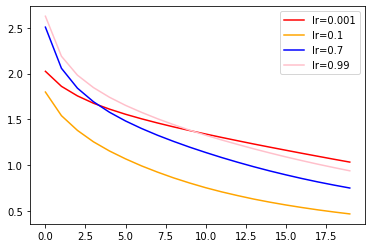

In [8]:
colors = ['red', 'orange', 'blue', 'pink']

for i in range(len(losses) // num_epochs):
  plt.plot(list(range(num_epochs)), losses[i * num_epochs: (i + 1) * num_epochs], 
              color=colors[i], label='lr=' + str(learning_rates[i]))
plt.legend()
plt.show()

In [24]:
#clr
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 20
start_lr = 1e-5
end_lr = 0.1
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        if k % 20 == 0:
          print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 1 of 20 took 20.265s
  training loss (in-iteration): 	2.047506
  validation accuracy: 			36.07 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 2 of 20 took 20.423s
  training loss (in-iteration): 	1.600241
  validation accuracy: 			42.59 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 3 of 20 took 20.294s
  training loss (in-iteration): 	1.362427
  validation accuracy: 			46.63 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 4 of 20 took 20.053s
  training loss (in-iteration): 	1.170942
  validation accuracy: 			48.13 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 5 of 20 took 20.072s
  training loss (in-iteration): 	1.028381
  validation accuracy: 			49.13 %
0 20 40 60 80 100 120 140 160 180 2

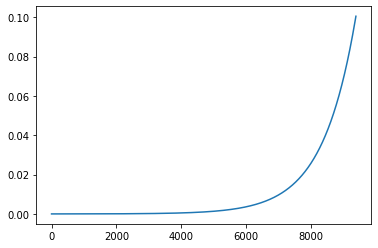

In [25]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

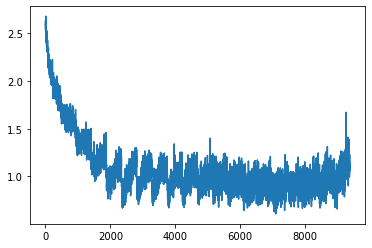

In [26]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [17]:
#clr
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 20
start_lr = 1e-3
end_lr = 0.7
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        if k % 20 == 0:
          print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 1 of 20 took 20.678s
  training loss (in-iteration): 	1.502681
  validation accuracy: 			49.25 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 2 of 20 took 20.399s
  training loss (in-iteration): 	1.083895
  validation accuracy: 			57.97 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 3 of 20 took 20.226s
  training loss (in-iteration): 	0.859203
  validation accuracy: 			54.16 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 4 of 20 took 20.149s
  training loss (in-iteration): 	0.664161
  validation accuracy: 			67.98 %
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 Epoch 5 of 20 took 20.159s
  training loss (in-iteration): 	0.467716
  validation accuracy: 			70.20 %
0 20 40 60 80 100 120 140 160 180 2

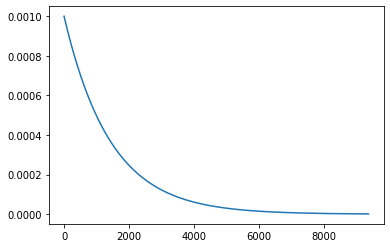

In [18]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

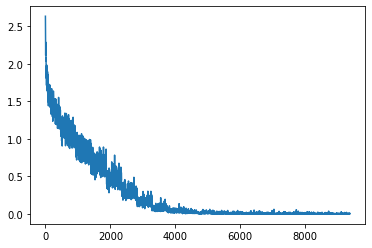

In [19]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()